In [51]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

from util.gmm import GMM

> ### 5.1 MDP example with bimodal rewards
> 
> In this simple MDP example, a player starts from initial state $A$, choose between two actions: go left to reach state $B$, or go right to reach state $C$. Both states $B$ and $C$ reveals a zero rewards. From state $B$, the player has only one action to reach state $D$ which reveals $n$ draws of rewards from a distribution $R_D$. From state $C$, the player has only one action to reach state $E$ which reveals $n$ draws of rewards from a distribution $R_E$. The reward distributions of states $D$ and $E$ are both multimodal distributions (for instance, the reward $r$ can be drawn from a bi-modal distribution of two normal distributions $N(\mu=10, \sigma=5)$ with probability $p = 0.3$ and $N(\mu=−5, \sigma=1)$ with $p = 0.7$). In the simulations, $n$ is set to be $50$. The left action (go to state $B$) by default is set to have an expected payout lower than the right action. However, the reward distributions can also be spread across both the positive and negative domains (as in the example shown in Figure 1).

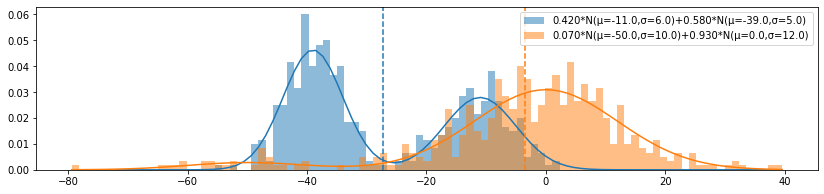

In [52]:
def plot_gmms(Rs, N=50, figsize=(14, 3)):
    X = np.array([R.rvs(N) for R in Rs])
    b = np.linspace(X.min(), X.max(), 100)
    plt.figure(figsize=figsize)
    for i, (x, R) in enumerate(zip(X, Rs)):
        plt.hist(x, density=True, bins=b, alpha=0.5, label=R)
        plt.axvline(R.mean(), linestyle="--", color=plt.cm.tab10(i))
        plt.plot(b, R.pdf(b), color=plt.cm.tab10(i))
    plt.legend()
    plt.show()

RD = GMM(coeffs=[0.42, 0.58], params=[[-11, 6], [-39, 5]])
RE = GMM(coeffs=[0.07, 0.93], params=[[-50, 10], [0, 12]])
    
plot_gmms([RD, RE], N=500)

> To better evaluate the robustness of the algorithms, we simulated 100 randomly generated scenarios of bi-modal distributions, where the reward distributions can be drawn from two normal distribution with means as random integers uniformly drawn from -100 to 100, standard deviations as random integers uniformly drawn from 0 to 20, and sampling distribution $p$ uniformly drawn from 0 to 1 (assigning $p$ to one normal distribution and $1−p$ to the other one). Each scenario was repeated 100 times.

OK they can't mean σ=0...? I'll take it from 1 to 20!

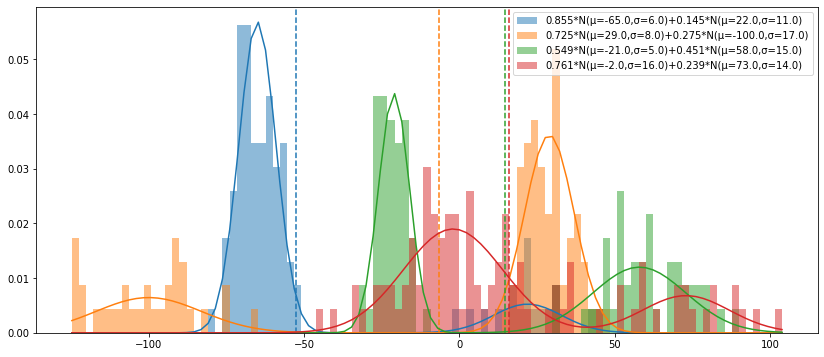

In [64]:
def random_gmm(loc_range=[-100, 101], scale_range=[1, 21], k=2):
    """
    Note: ranges are half-open intervals
    """    
    mu0, mu1 = np.random.randint(*loc_range,   size=k)
    sd0, sd1 = np.random.randint(*scale_range, size=k)
    ps = scipy.stats.dirichlet.rvs(np.ones(k))[0]
    return GMM(coeffs=ps, params=[[mu0, sd0], [mu1, sd1]])

def random_gmms(n=2, **kwargs):
    return sorted([random_gmm(**kwargs) for _ in range(n)], key=GMM.mean)

plot_gmms(random_gmms(n=4), N=100, figsize=(14, 6))

In [99]:
class BimodalMDP:
    def __init__(self, R1, R2, N=50, split_rewards=True, random_seed=None):
        self.action_space = ["left", "right", "straight"]
        self.split_rewards = split_rewards
        self.R1 = R1
        self.R2 = R2
        self.N = N
        self.reset()
    def reset(self):
        self.state = 0
        return self.state
    def step(self, action):
        if self.state == 0:
            if action == "left":
                self.state = 1
                reward = np.zeros(1)
                done = False
            elif action == "right":
                self.state = 2
                reward = np.zeros(1)
                done = False
            else:
                raise Exception("Invalid action in state 0.")
        elif self.state == 1:
            if action == "straight":
                self.state = 3
                reward = self.R1.rvs(self.N)
                done = True
            else:
                raise Exception("Invalid action in state 1.")
        elif self.state == 2:
            if action == "straight":
                self.state = 3
                reward = self.R2.rvs(self.N)
                done = True
            else:
                raise Exception("Invalid action in state 2.")
        else:
            raise Exception("Invalid action in state 3.")
        if not self.split_rewards:
            reward = sum(reward)
        return self.state, reward, done, {}
    def render(self, end="\r", **kwargs):
        print("BimodalMDP (state {}).".format(self.state),
              end=end, **kwargs)
    def close(self, **kwargs):
        print(**kwargs)


# agent that always goes left
pi = ['left', 'straight', 'straight']

# run an episode
env = BimodalMDP(*random_gmms(), split_rewards=True, N=10)
done = False
s = env.reset()
env.render(end="\n")
while not done:
    a = pi[s]
    print('action:', a)
    s, r, done, _ = env.step(pi[s])
    print('reward:', r.round(1))
    env.render(end="\n")
env.close()

BimodalMDP (state 0).
action: left
reward: [0.]
BimodalMDP (state 1).
action: straight
reward: [-39.9 -41.3 -38.7 -34.3 -42.5 -34.6 -39.  -39.  -35.5 -58.9]
BimodalMDP (state 3).

